In [5]:
import numpy as np
def create_circle(cx, cy, r, num=50):
    increment = 2*np.pi / num
    boundary = []
    for i in range(num):
        angle = i * increment
        x = cx + r * np.cos(angle)
        y = cy + r * np.sin(angle)
        boundary.append((x, y))
    boundary.append(boundary[0]) 
    return np.array(boundary)

runtime: 31.210761916998308 sec.


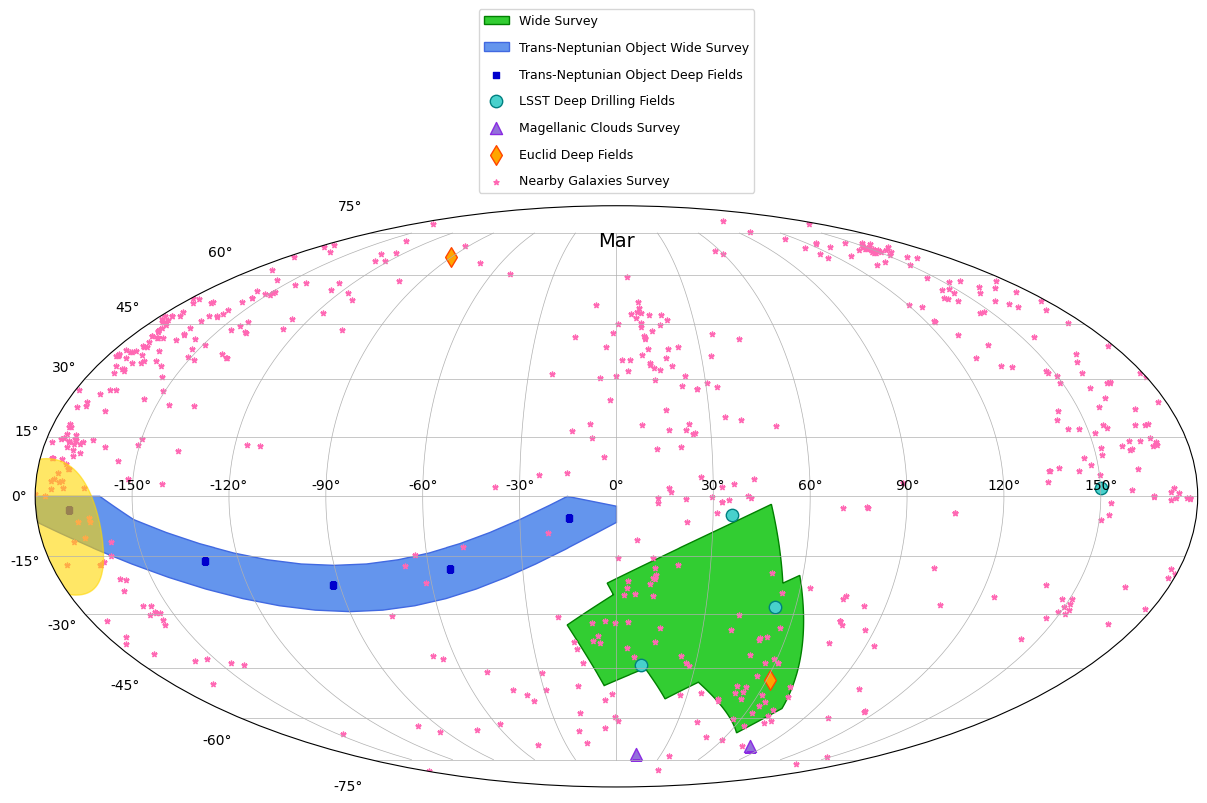

In [54]:
import numpy as np
import matplotlib
import matplotlib.patches as p
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from shapely.geometry import Polygon
from IPython.display import HTML

from operations import hms_to_deg, dms_to_deg

Wide = np.loadtxt('Wide.txt', skiprows=1)
TNO = np.loadtxt('TNO.txt')
xmin, ymin, xmax, ymax = Polygon(TNO).bounds
xDeep = np.linspace(xmin+10, xmax-15, 5)
yDeep = np.array([-3, -16, -22, -18, -5])
NGS = np.loadtxt('NGS.txt')

LMC = (hms_to_deg(5, 23, 34), dms_to_deg(-69, 45, 22))
SMC = (hms_to_deg(0, 52, 45), dms_to_deg(-72, 49, 43))
EDFN = (hms_to_deg(17, 58, 55.9), dms_to_deg(66, 1, 3.7))
EDFS = (hms_to_deg(4, 4, 57.84), dms_to_deg(-48, 25, 22.8))

ELAIS_S1 = (hms_to_deg(0, 37, 48), dms_to_deg(-44, 0, 0))
XMM_LSS = (hms_to_deg(2, 22, 50), dms_to_deg(-4, 45, 0))
ECDFS = (hms_to_deg(3, 32, 30), dms_to_deg(-28, 6, 0))
COSMOS = (hms_to_deg(10, 0, 24), dms_to_deg(2, 10, 55))

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': 'mollweide'})
ax.grid(True, linewidth=0.5, zorder=0) 

ax.add_patch(p.Polygon(np.radians(Wide), facecolor='limegreen', edgecolor='green', label='Wide Survey'))
ax.add_patch(p.Polygon(np.radians(TNO), facecolor='cornflowerblue', edgecolor='royalblue', label='Trans-Neptunian Object Wide Survey'))
ax.scatter(np.radians(xDeep+0.4), np.radians(yDeep-0.4), marker='s', s=20, color='mediumblue', label='Trans-Neptunian Object Deep Fields')
ax.scatter(np.radians(ELAIS_S1[0]), np.radians(ELAIS_S1[1]), marker='o', s=80, color='mediumturquoise', ec='teal', label='LSST Deep Drilling Fields')
ax.scatter(np.radians(XMM_LSS[0]), np.radians(XMM_LSS[1]), marker='o', s=80, color='mediumturquoise', ec='teal')
ax.scatter(np.radians(ECDFS[0]), np.radians(ECDFS[1]), marker='o', s=80, color='mediumturquoise', ec='teal')
ax.scatter(np.radians(COSMOS[0]), np.radians(COSMOS[1]), marker='o', s=80, color='mediumturquoise', ec='teal')
ax.scatter(np.radians(LMC[0]), np.radians(LMC[1]), marker='^', s=75, color='mediumpurple', ec='blueviolet', label='Magellanic Clouds Survey')
ax.scatter(np.radians(SMC[0]), np.radians(SMC[1]), marker='^', s=75, color='mediumpurple', ec='blueviolet')
ax.scatter(np.radians(EDFN[0]), np.radians(EDFN[1]), marker='d', s=100, color='orange', ec='orangered', label='Euclid Deep Fields')
ax.scatter(np.radians(EDFS[0]), np.radians(EDFS[1]), marker='d', s=100, color='orange', ec='orangered')
ax.scatter(np.radians(NGS[:,0]), np.radians(NGS[:,1]), marker='*', s=15, color='hotpink', label='Nearby Galaxies Survey')
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.18), fontsize=9, labelspacing=1.1)

# lamda is "sun" ecliptic longitude --> lamda = 0° on March 21st for Sun 
# on March 21 st, CVZ will center on lamda = -180°
# CVZ sweeps clockwise across the sky 
def direction(lamda):
    RA = []
    for i in lamda:
        RA.append(i + 2.45 * np.sin(np.radians(2*i)))
    return RA
# traverse from March 21st onwards
lamda = np.arange(-180, 180, step=360/365.25)
# gives the daily position starting on March 21st. 
traverse = direction(lamda)
# First day of every month starting on Apr 1st.
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
index = [11, 41, 72, 102, 133, 164, 194, 225, 255, 286, 317, 345]
month_positions = np.radians([traverse[i] for i in index])

# Create the initial CVZ (Continuous Viewing Zone) circle
x_position = -180  # start at the left edge of the projection
circle_boundary = create_circle(np.radians(x_position), np.radians(-7.8), np.radians(17.3), num=100)
CVZ = p.Polygon(circle_boundary, closed=True, color='gold', alpha=0.6)
ax.add_patch(CVZ)

# Add the month label text at the bottom of the plot, initially blank
month_text = ax.text(0, np.radians(70), '', color='black', fontsize=14, ha='center')
# Initial month
current_month = 'Mar'

def animate(i):
    global x_position, current_month  
    # Update the x-position of the circle 
    x_position += 2  # Move right by 2 degrees each frame 
    if x_position > 180:  # Reset position if it goes off-screen
        x_position = -180
    
    # Update the circle boundary with the new x-position
    circle_boundary = create_circle(np.radians(x_position), np.radians(-7.8), np.radians(17.3), num=100)
    CVZ.set_xy(circle_boundary)

    # Initialize a variable to track if a month change occurred
    month_changed = False

    # Check if circle center is close to any month position
    for j, month_x in enumerate(month_positions):
        if abs(np.radians(x_position) - month_x) < np.radians(2):  # 2-degree tolerance
            if current_month != month[j]:  # Update only if the month has changed
                current_month = month[j]
                month_text.set_text(current_month)  # Update month text
                month_changed = True  # Indicate a change has occurred
            break

    # If no month change was detected, keep the current month displayed
    if not month_changed:
        month_text.set_text(current_month)

    return CVZ, month_text

import timeit
code_start = timeit.default_timer()

# Set up the animation
ani = FuncAnimation(fig, animate, frames=np.arange(0, 360, 2), interval=200)
plt.rcParams["animation.html"] = "jshtml"
# HTML(ani.to_jshtml())
# matplotlib.rcParams['animation.embed_limit'] = 2**128
writergif = matplotlib.animation.PillowWriter(fps=20) 
ani.save('survey map.gif', writer=writergif, dpi=150)  # increase dpi for more detail

runtime = timeit.default_timer() - code_start
print(f"runtime: {runtime} sec.")

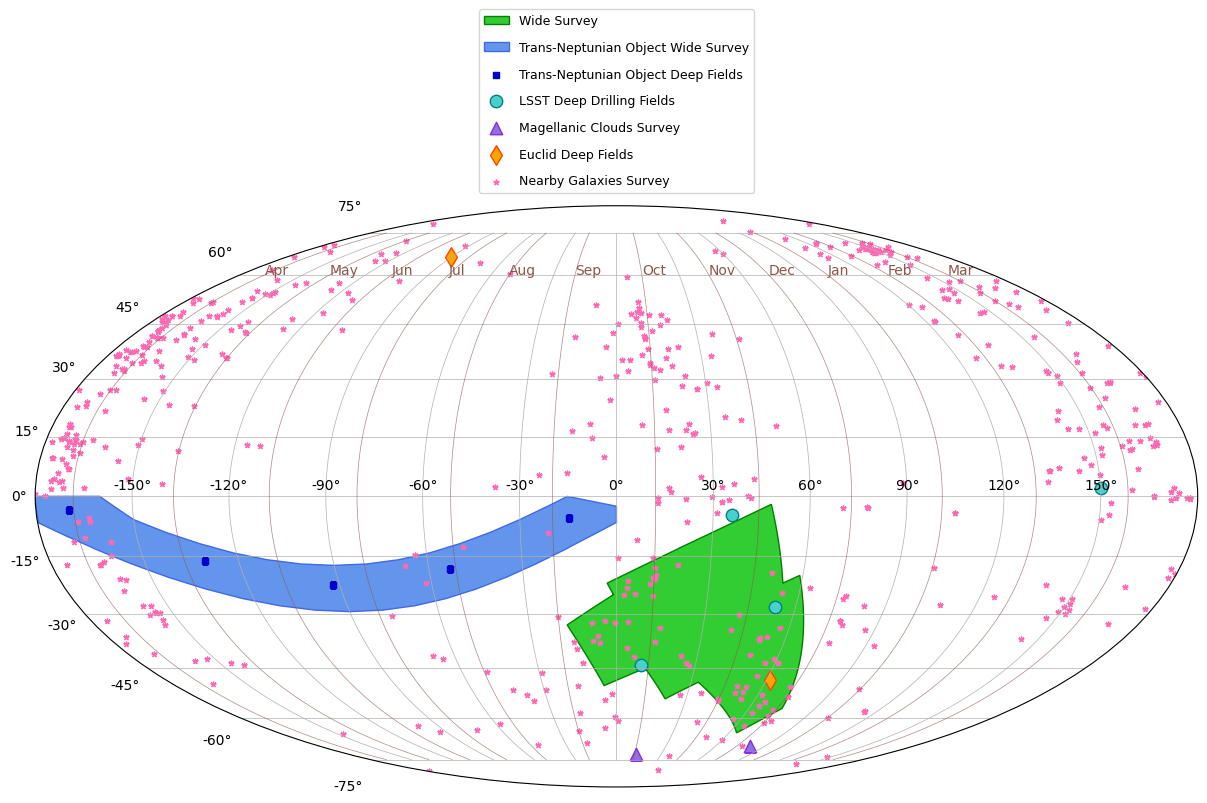

In [45]:
import numpy as np
import matplotlib.patches as p
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

Wide = np.loadtxt('Wide.txt', skiprows=1)
TNO = np.loadtxt('TNO.txt')
xmin, ymin, xmax, ymax = Polygon(TNO).bounds
xDeep = np.linspace(xmin+10, xmax-15, 5)
yDeep = np.array([-3, -16, -22, -18, -5])
NGS = np.loadtxt('NGS.txt')

LMC = (hms_to_deg(5, 23, 34), dms_to_deg(-69, 45, 22))
SMC = (hms_to_deg(0, 52, 45), dms_to_deg(-72, 49, 43))
EDFN = (hms_to_deg(17, 58, 55.9), dms_to_deg(66, 1, 3.7))
EDFS = (hms_to_deg(4, 4, 57.84), dms_to_deg(-48, 25, 22.8))

ELAIS_S1 = (hms_to_deg(0, 37, 48), dms_to_deg(-44, 0, 0))
XMM_LSS = (hms_to_deg(2, 22, 50), dms_to_deg(-4, 45, 0))
ECDFS = (hms_to_deg(3, 32, 30), dms_to_deg(-28, 6, 0))
COSMOS = (hms_to_deg(10, 0, 24), dms_to_deg(2, 10, 55))

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'projection': 'mollweide'})
ax.grid(True, linewidth=0.5, zorder=0) 

# lamda is "sun" ecliptic longitude --> lamda = 0° on March 21st for Sun 
# on March 21 st, CVZ will center on lamda = -180°
# CVZ sweeps clockwise across the sky 
def direction(lamda):
    RA = []
    for i in lamda:
        RA.append(i + 2.45 * np.sin(np.radians(2*i)))
    return RA
# traverse from March 21st onwards
lamda = np.arange(-180, 180, step=360/365.25)
# gives the daily position starting on March 21st. 
traverse = direction(lamda)
# First day of every month starting on Apr 1st.
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
index = [11, 41, 72, 102, 133, 164, 194, 225, 255, 286, 317, 345]
for i, name in zip(index, month):
    ax.text(np.radians(traverse[i]), np.radians(60), name, color='tab:brown')
    plt.axvline(x=np.radians(traverse[i]), color='tab:brown', alpha=0.7, linewidth=0.5)

ax.add_patch(p.Polygon(np.radians(Wide), facecolor='limegreen', edgecolor='green', label='Wide Survey'))
ax.add_patch(p.Polygon(np.radians(TNO), facecolor='cornflowerblue', edgecolor='royalblue', label='Trans-Neptunian Object Wide Survey'))
ax.scatter(np.radians(xDeep+0.4), np.radians(yDeep-0.4), marker='s', s=20, color='mediumblue', label='Trans-Neptunian Object Deep Fields')
ax.scatter(np.radians(ELAIS_S1[0]), np.radians(ELAIS_S1[1]), marker='o', s=80, color='mediumturquoise', ec='teal', label='LSST Deep Drilling Fields')
ax.scatter(np.radians(XMM_LSS[0]), np.radians(XMM_LSS[1]), marker='o', s=80, color='mediumturquoise', ec='teal')
ax.scatter(np.radians(ECDFS[0]), np.radians(ECDFS[1]), marker='o', s=80, color='mediumturquoise', ec='teal')
ax.scatter(np.radians(COSMOS[0]), np.radians(COSMOS[1]), marker='o', s=80, color='mediumturquoise', ec='teal')
ax.scatter(np.radians(LMC[0]), np.radians(LMC[1]), marker='^', s=80, color='mediumpurple', ec='blueviolet', label='Magellanic Clouds Survey')
ax.scatter(np.radians(SMC[0]), np.radians(SMC[1]), marker='^', s=80, color='mediumpurple', ec='blueviolet')
ax.scatter(np.radians(EDFN[0]), np.radians(EDFN[1]), marker='d', s=100, color='orange', ec='orangered', label='Euclid Deep Fields')
ax.scatter(np.radians(EDFS[0]), np.radians(EDFS[1]), marker='d', s=100, color='orange', ec='orangered')
ax.scatter(np.radians(NGS[:,0]), np.radians(NGS[:,1]), marker='*', s=15, color='hotpink', label='Nearby Galaxies Survey')
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.18), fontsize=9, labelspacing=1.1)
plt.show()

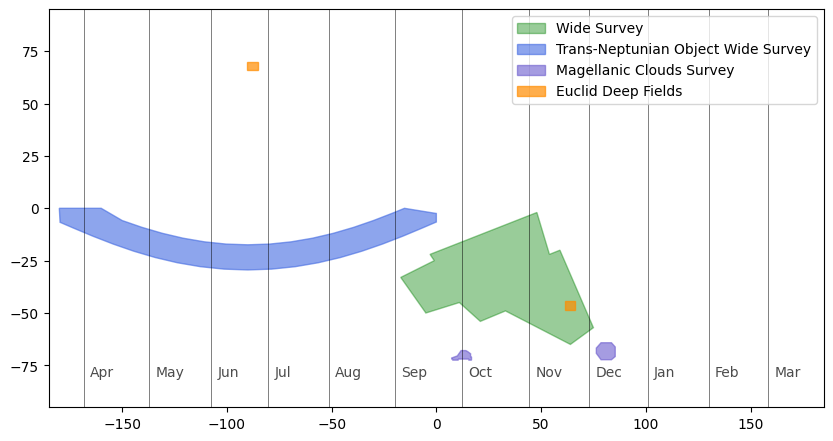

In [151]:
import numpy as np
import matplotlib.patches as p
import matplotlib.pyplot as plt

from operations import hms_to_deg, dms_to_deg

Wide = np.loadtxt('Wide.txt', skiprows=1)
TNO = np.loadtxt('TNO.txt')
LMC = np.loadtxt('LMC.txt')
SMC = np.loadtxt('SMC.txt')
NGS = np.loadtxt('NGS.txt')
EDFN_center = (hms_to_deg(17, 58, 55.9), dms_to_deg(66, 1, 3.7))
EDFS_center = (hms_to_deg(4, 4, 57.84), dms_to_deg(-48, 25, 22.8))

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.axis([-185, 185, -95, 95])
ax.set_aspect('equal')

# lamda is "sun" ecliptic longitude --> lamda = 0° on March 21st for Sun 
# on March 21 st, CVZ will center on lamda = -180°
# CVZ sweeps clockwise across the sky 
def direction(lamda):
    RA = []
    for i in lamda:
        RA.append(i + 2.45 * np.sin(np.radians(2*i)))
    return RA
# traverse from March 21st onwards
lamda = np.arange(-180, 180, step=360/365.25)
# gives the daily position starting on March 21st. 
traverse = direction(lamda)
# First day of every month starting on Apr 1st.
month = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
index = [11, 41, 72, 102, 133, 164, 194, 225, 255, 286, 317, 345]
for i, name in zip(index, month):
    plt.axvline(x=traverse[i], color='black', alpha=0.7, linewidth=0.5)
    ax.text(traverse[i]+3, -80, name, alpha=0.7)

ax.add_patch(p.Polygon(Wide, facecolor='green', alpha=0.4, edgecolor='green', label='Wide Survey'))
ax.add_patch(p.Polygon(TNO, facecolor='royalblue', alpha=0.6, edgecolor='royalblue', label='Trans-Neptunian Object Wide Survey'))
ax.add_patch(p.Polygon(LMC, facecolor='slateblue', alpha=0.6, edgecolor='slateblue', label='Magellanic Clouds Survey'))
ax.add_patch(p.Polygon(SMC, facecolor='slateblue', alpha=0.6, edgecolor='slateblue'))
ax.add_patch(p.Rectangle(EDFN_center, width=5, height=4, facecolor='darkorange', alpha=0.7, edgecolor='darkorange',label='Euclid Deep Fields'))
ax.add_patch(p.Rectangle(EDFS_center, width=5, height=4, facecolor='darkorange', alpha=0.7, edgecolor='darkorange'))
plt.legend()
plt.show()

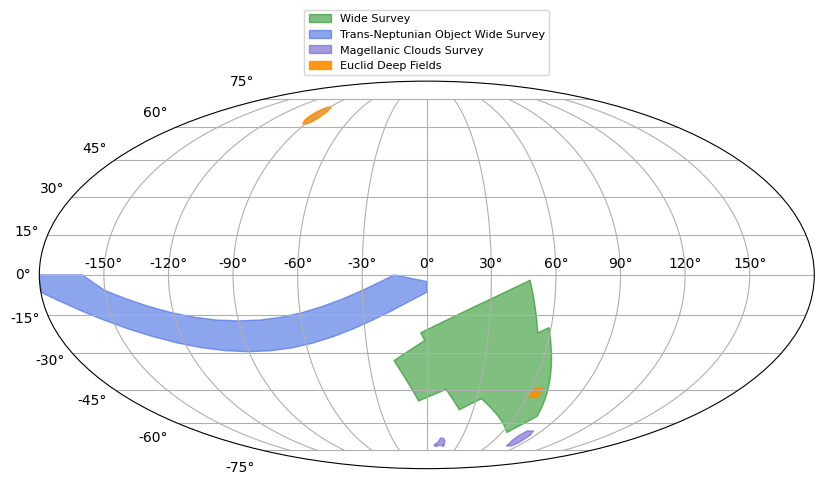

In [91]:
import numpy as np
import matplotlib.patches as p
import matplotlib.pyplot as plt

Wide = np.loadtxt('Wide.txt', skiprows=1)
TNO = np.loadtxt('TNO.txt')
LMC = np.loadtxt('LMC.txt')
SMC = np.loadtxt('SMC.txt')
NGS = np.loadtxt('NGS.txt')
EDFN_center = (hms_to_deg(17, 58, 55.9), dms_to_deg(66, 1, 3.7))
EDFS_center = (hms_to_deg(4, 4, 57.84), dms_to_deg(-48, 25, 22.8))

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'mollweide'})
ax.grid(True)

# ax.scatter(np.radians(), np.radians(), color='mediumturquoise', s=60, label='Cadence Survey: LSST-DDF')
# ax.scatter(XMM_LSS[0], XMM_LSS[1], color='mediumturquoise', s=60)
# ax.scatter(Chandra[0], Chandra[1], color='mediumturquoise', s=60)
# ax.scatter(COSMOS[0], COSMOS[1], color='mediumturquoise', s=60)

ax.add_patch(p.Polygon(np.radians(Wide), facecolor='green', alpha=0.5, edgecolor='green', label='Wide Survey'))
ax.add_patch(p.Polygon(np.radians(TNO), facecolor='royalblue', alpha=0.6, edgecolor='royalblue', label='Trans-Neptunian Object Wide Survey'))
ax.add_patch(p.Polygon(np.radians(LMC), facecolor='slateblue', alpha=0.6, edgecolor='slateblue', label='Magellanic Clouds Survey'))
ax.add_patch(p.Polygon(np.radians(SMC), facecolor='slateblue', alpha=0.6, edgecolor='slateblue'))
# ax.add_patch(p.Rectangle(np.radians(EDFN_center), width=np.radians(5), height=np.radians(4), facecolor='darkorange', alpha=0.9, edgecolor='darkorange',label='Euclid Deep Fields'))
ax.add_patch(p.Rectangle(np.radians(EDFS_center), width=np.radians(5), height=np.radians(4), facecolor='darkorange', alpha=0.9, edgecolor='darkorange'))
ax.add_patch(p.Circle(np.radians(EDFN_center), radius=np.radians(4.45), facecolor='darkorange', alpha=0.9, edgecolor='darkorange', label='Euclid Deep Fields'))
# ax.add_patch(p.Circle(np.radians(EDFS_center), radius=np.radians(4.45), facecolor='darkorange', alpha=0.9, edgecolor='darkorange'))
#ax.scatter(np.radians(hms_to_deg(4, 4, 57.84)), np.radians(dms_to_deg(-48, 25, 22.8)), marker='s', s=60, color='darkorange')
plt.legend(loc='center', bbox_to_anchor=(0.5, 1.1), fontsize=8)
plt.show()